# Data Exploration


## Sentiment140 Dataset

The Sentiment140 dataset consists of 1,600,000 tweets collected using the Twitter API. These tweets have been annotated for sentiment, with the polarity labeled as 0 (negative), 2 (neutral), or 4 (positive). The dataset is commonly used for sentiment analysis tasks and sentiment classification.

The dataset contains the following six fields:

- **target**: The polarity of the tweet, where 0 represents negative sentiment, 2 represents neutral sentiment, and 4 represents positive sentiment.
- **ids**: The unique identifier of the tweet.
- **date**: The date and time the tweet was posted in UTC format.
- **flag**: The query associated with the tweet. If there is no query, the value is labeled as NO_QUERY.
- **user**: The username of the Twitter user who posted the tweet.
- **text**: The actual text content of the tweet.

This dataset was created for sentiment analysis research and can be used to train models or develop algorithms to detect sentiment in text data, specifically tweets.

### Key Points
- 1,600,000 tweets with sentiment annotations (0 = negative, 2 = neutral, 4 = positive).
- Extracted using the Twitter API.
- Fields include target, ids, date, flag, user, and text.
- Used for sentiment analysis and sentiment classification tasks.
- Valuable resource for training models and developing sentiment analysis algorithms.

Please note that this dataset was originally introduced in a research project conducted at Stanford University, and the official link and paper are provided for further reference and citation.

### Acknowledgements
- [Kaggle Dataset Link](https://www.kaggle.com/kazanova/sentiment140)

### Reference/Citation
Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.



In [1]:
# Install all required packages
#!pip install matplotlib
#!pip install transformers
#!pip install torch #Make sure to install the correct version of torch for your system (GPU or CPU)
#!pip install scikit-learn
#!pip install pandas
#!pip install numpy
#!pip install tqdm
#!pip install nltk



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
original_dataset = pd.read_csv("dataset.csv", encoding="latin-1", engine='pyarrow')
original_dataset.columns = ["label", "time", "date", "query", "username", "text"]
original_dataset.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In the process of fine-tuning the BERT model for sentiment analysis, it is not necessary to include certain columns such as date, username, query, and id. We can focus solely on utilizing the text and target columns.

In [4]:
dataset = original_dataset.drop(["time", "date", "query", "username"], axis=1)
dataset = dataset.sample(frac=.1).reset_index(drop=True)
dataset.head()

,label,text
0,4,Another day @ home resting my knee after knees...
1,4,Had a really great weekend with family and got...
2,0,@xoAdrianne how am i gonna find you downtown?
3,0,is goin over romanian numbers.. boringg :L
4,4,@mileycyrus you have to play in san diego


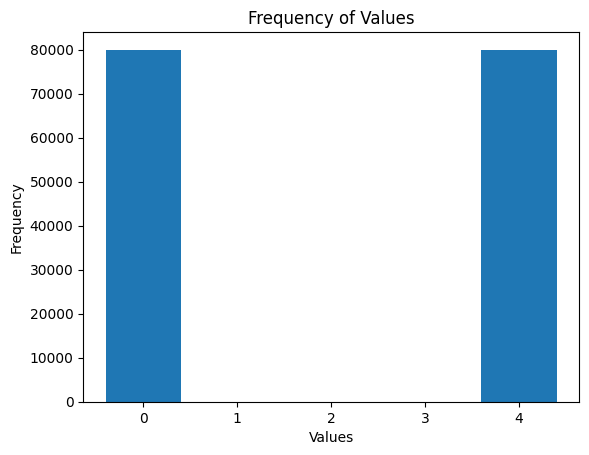

In [5]:
value_counts = dataset['label'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Values')
plt.show()



Although the description of the dataset states that the target column contains values of 0, 2, and 4, the actual values in the dataset are 0 and 4. This means that there are only two classes of sentiment in the dataset: negative and positive. We will transform the values in the target column to 0 and 1 to make it easier to work with.

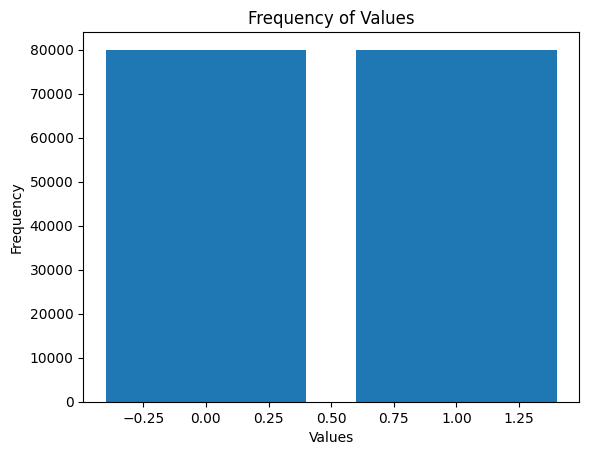

In [6]:
# transform the labels from 4 to 1
dataset['label'] = dataset['label'].replace(4, 1)
value_counts = dataset['label'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Values')
plt.show()

# Fine Tuning BERT

Now that we have a better understanding of the dataset, we can begin fine-tuning the BERT model for sentiment analysis. We will use the transformers library by Hugging Face to fine-tune the pretrained BERT model for sentiment classification. The transformers library provides a wide variety of pretrained transformer models along with the necessary methods and classes to fine-tune language models to suit a given NLP task.

In [7]:
#pip install transformers

## Before we fine-tune

We need to preprocess the text to remove any special characters and @user mentions. We will also split the dataset into training and validation sets.

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2, random_state=42)

del dataset, original_dataset # free up some memory


Because BERT was trained on full sentences, we don't have to remove stop words or punctiation. This text however does contain links, and other errors that we must fix. We will use the transformers library to tokenize and encode the sentences in the dataset.

In [9]:
import re

def text_preprocessing(text):
    # Remove entity mentions starting with '@user'
    text = re.sub(r'@\w+', '', text)
    
    # Remove URLs
    text = re.sub(r'(http|https)://[^\s]+', '', text)
    
    # Remove text between two asterisks -- Usually emojis/symbols in the dataset
    text = re.sub(r'\*.*?\*', '', text)
    
    # Correct common errors
    text = text.replace('&amp;', '&')
    
    # Remove excess whitespace characters
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



Now we just preprocess the text

In [10]:
x_train = x_train.apply(lambda text: text_preprocessing(text))
x_test = x_test.apply(lambda text: text_preprocessing(text))
x_train

150477                                                     
115280    I just woke up and watched your cover of Hush ...
129628                     nooo hopefully I will tonight =]
50780                                      i could do that!
36702     Thinking of japanizing my name... æ¹å´ç? ç?...
                                ...                        
119879    Awwhh not good Ive never seen pink hair dye.. ...
103694                    Ah no! My honey just woke up sick
131932    goood morning, winter concert today, miss most...
146867    had an awesome time at Revo Conference! Big th...
121958    In 1977, Elvis Presley made his final live con...
Name: text, Length: 128000, dtype: object

To use a pre-trained BERT model effectively, you need to use the provided tokenizer because the model has a fixed vocabulary, and the tokenizer handles out-of-vocabulary words. Special tokens should be added at the start and end of each sentence, sentences should be padded or truncated to a consistent length, and an attention mask is used to identify padding tokens. We will use the transformer library to do so

In [11]:
from transformers import BertTokenizer
import torch



In [12]:
def preprocess_for_bert(data):
    # Initialize lists to store the input_ids and attention_masks
    input_ids = []
    attention_masks = []

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    
    for text in tqdm(data):
        # Use tokenizer.encode_plus to tokenize and encode the text
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            pad_to_max_length=True,
            max_length=360, # Determined from the processed text
            return_attention_mask=True,
        )

        # Add the input_ids and attention_mask to the lists
        input_ids.append(encoded.get('input_ids'))
        attention_masks.append(encoded.get('attention_mask'))

    # Convert the lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)


    return input_ids, attention_masks


Now we can tokenize the data

In [13]:
x_train

150477                                                     
115280    I just woke up and watched your cover of Hush ...
129628                     nooo hopefully I will tonight =]
50780                                      i could do that!
36702     Thinking of japanizing my name... æ¹å´ç? ç?...
                                ...                        
119879    Awwhh not good Ive never seen pink hair dye.. ...
103694                    Ah no! My honey just woke up sick
131932    goood morning, winter concert today, miss most...
146867    had an awesome time at Revo Conference! Big th...
121958    In 1977, Elvis Presley made his final live con...
Name: text, Length: 128000, dtype: object

Tokenizing will take a while because of how large the dataset is
For me it was ~ 20 minutes

In [14]:


train_inputs, train_masks = preprocess_for_bert(x_train)
print('Done training preprocessing.')
test_inputs, test_masks = preprocess_for_bert(x_test)
print('Done testing preprocessing.')



100%|██████████| 128000/128000 [00:58<00:00, 2196.76it/s]


Done training preprocessing.


100%|██████████| 32000/32000 [00:14<00:00, 2216.72it/s]


Done testing preprocessing.


In [15]:
print('Original: ', x_train)
print('Tokenized: ', train_masks)

Original:  150477                                                     
115280    I just woke up and watched your cover of Hush ...
129628                     nooo hopefully I will tonight =]
50780                                      i could do that!
36702     Thinking of japanizing my name... æ¹å´ç? ç?...
                                ...                        
119879    Awwhh not good Ive never seen pink hair dye.. ...
103694                    Ah no! My honey just woke up sick
131932    goood morning, winter concert today, miss most...
146867    had an awesome time at Revo Conference! Big th...
121958    In 1977, Elvis Presley made his final live con...
Name: text, Length: 128000, dtype: object
Tokenized:  tensor([[1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


# Now we can create a Data Loader from Torch

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert the labels to tensors
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

# Batch Size 
batch_size = 12

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



# Finally, we can fine-tune the model

In [17]:
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits


# Create an Optimizer to Fine Tune the Model

In [18]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

def init_model(epochs=4):
    bert_classifier = BertClassifier(freeze=False)

    # Run GPU

    bert_classifier.to('cuda')

    optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    return bert_classifier, optimizer, scheduler

# Training Loop

In [19]:
import time
import random
import gc
# Loss
loss_fn = nn.CrossEntropyLoss()

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed_all(20)

def train(bert_classifier, optimizer, scheduler, epochs=4):

    for epoch in tqdm(range(epochs)):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        bert_classifier.train()

        progress_bar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch}', position=0)
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            # Load batch to GPU
            batch_inputs, batch_masks, batch_labels = tuple(t.to('cuda') for t in batch)

            # Zero out gradients
            bert_classifier.zero_grad()

            # Perform a forward pass.
            logits = bert_classifier(batch_inputs, batch_masks)

            # Compute loss
            loss = loss_fn(logits, batch_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass
            loss.backward()

            
            # Clip norm
            torch.nn.utils.clip_grad_norm_(bert_classifier.parameters(), 1.0)

            # step optimizer, update params
            optimizer.step()
            scheduler.step()

            # Progress update every 20 batches.
            # if step % 20 == 0 and not step == 0:
            #     # Calculate elapsed time in minutes.
            #     elapsed = time.time() - t0_batch

            #     # Print training results
            #     print(f"{epoch:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {elapsed:^9.2f}")

            #     # Reset batch tracking variables
            #     batch_loss, batch_counts = 0, 0
            #     t0_batch = time.time()
            progress_bar.update(1)
            progress_bar.set_postfix({'Elapsed': time.time() - t0_epoch, 'Loss': total_loss / batch_counts})
        
        # Calculate the average loss
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*100)
        




In [20]:
def eval_model(bert_classifier, dataloader):

    #Set to eval mode
    bert_classifier.eval()

    #Tracking
    val_acc = []
    val_loss = []

    for batch in tqdm(dataloader):

        #Load to GPU
        batch_inputs, batch_masks, batch_labels = tuple(t.to('cuda') for t in batch)

        #Forward pass
        with torch.no_grad():
            logits = bert_classifier(batch_inputs, batch_masks)

        #Compute loss
        loss = loss_fn(logits, batch_labels)
        val_loss.append(loss.item())

        #Get predictions
        preds = torch.argmax(logits, dim=1).flatten()

        #Calculate accuracy
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        val_acc.append(accuracy)

    #Compute the average accuracy and loss over the validation set
    val_acc = np.mean(val_acc)
    val_loss = np.mean(val_loss)

    return val_acc, val_loss



# Begin Training

In [21]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [22]:
bert_classifer, optimizer, scheduler = init_model(epochs=4)
train(bert_classifer, optimizer, scheduler, epochs=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/4 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 


 25%|██▌       | 1/4 [1:05:58<3:17:54, 3958.21s/it]0,  3.00it/s, Elapsed=3.96e+3, Loss=0.422]

----------------------------------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 


 50%|█████     | 2/4 [2:11:28<2:11:23, 3941.76s/it]0,  2.99it/s, Elapsed=3.93e+3, Loss=0.334]

----------------------------------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 


 75%|███████▌  | 3/4 [3:16:57<1:05:35, 3935.78s/it]0,  2.98it/s, Elapsed=3.93e+3, Loss=0.25] 

----------------------------------------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 


Epoch 3: 100%|██████████| 10667/10667 [1:04:56<00:00,  2.74it/s, Elapsed=3.9e+3, Loss=0.164]

----------------------------------------------------------------------------------------------------


## Evaluate the Model on Validation Set

In [23]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to('cuda') for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [24]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9129
Accuracy: 83.65%


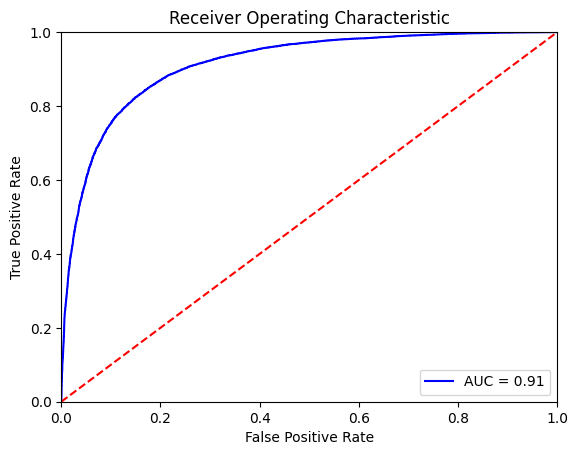

In [25]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifer, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

# Save the Model


In [26]:
path = 'bert_classifier.pt'
torch.save(bert_classifer.state_dict(), path)